# Assignment 2
**Group nr: 25 <br>**
Erik Wold Riise, s194633 <br>
Lukas Rasocha, s233498 <br>
Zou Yong Nan Klaassen, s230351 <br>

# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2024/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday November 5th, 2024 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

## Imports

In [89]:
import networkx as nx
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import community as community_louvain

from networkx.algorithms.community import modularity
from fa2_modified import ForceAtlas2
from collections import defaultdict, Counter


In the exercises below, I describe the exercises in a general way. Drawing in the right parts of the exercises is part of the assignment. (That way we're helping you get a little bit more ready for the Final Project, where you have to decide what information to include in your report and analysis). 


# Part 1: Genres and communities and plotting 🧑‍🤝‍🧑

The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.


#### 1.0 Setup

First we load and create the graph

where we do the following:
- Remove all self-loops 
- Turn the graph into an undirected graph
- Create a subgraph based on the file provided by the TAs in week 7

In [112]:
graph_path = 'country_performers_network.graphml'
G = nx.read_graphml(graph_path)

genre_dict_path = 'artists_genres_dictionary.txt'
with open(genre_dict_path, 'r') as f:
    genre_dict = json.load(f)

# Helper function to normalize names for matching, replacing underscores with spaces because we have underscores in the graphml file
def normalize_name(name):
    return name.replace('_', ' ').lower().strip()

normalized_genre_dict = {normalize_name(k): v for k, v in genre_dict.items()}

filtered_nodes = {}
for node in G.nodes():
    normalized_node = normalize_name(node)
    if normalized_node in normalized_genre_dict:
        primary_genre = normalized_genre_dict[normalized_node][0]  # First we will try using the first genre in the list
        filtered_nodes[node] = primary_genre
        G.nodes[node]['genre'] = primary_genre  

nodes_with_genre = set(filtered_nodes.keys())
G_filtered = G.subgraph(nodes_with_genre).copy()

print("Number of nodes with genre:", len(G_filtered.nodes))
print("Examples:", list(G_filtered.nodes(data=True))[:2])
print("Number of edges directed:", len(G_filtered.edges))

G_filtered = G_filtered.to_undirected()
G_filtered.remove_edges_from(nx.selfloop_edges(G_filtered))
print("Number of edges undirected:", len(G_filtered.edges))

Number of nodes with genre: 1832
Examples: [('Mandy_Barnett', {'length': 1989, 'genre': 'country'}), ('Jo_Hikk', {'length': 499, 'genre': 'country'})]
Number of edges directed: 16731
Number of edges undirected: 14083


#### 1.1: Write about genres and modularity.

We will use the concept of modularity to figure out how community-like the different genres are. Modularity is a measure that tells us well community-partitioned a network is. Networks with high modularity (close to 1) have dense connections between the nodes within communities but sparse connections between nodes in different communities. [[reference](https://en.wikipedia.org/wiki/Modularity_(networks))]

The formula is given by:

$$M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]$$


where:
* $n_c$ is the number of communities
* $L_c$ is the number of links in community $c$
* $L$ is the total number of links in the network
* $k_c$ is the sum of the degrees of the nodes in community $c$

Or in simpler words, we will pretend as if the genres are the communities and calculate the modularity of the network, if the modularity is high, then the genres serve as good communities.

Here we first implement the modularity function from scratch, it takes the graph $G$ and the specified partition as input and returns the modularity of the partition.

In [84]:
def calculate_modularity(G, community_partition):
    L = G.size(weight='weight')
    community_edges = defaultdict(float)
    community_degrees = defaultdict(float)
    
    node_to_community = {}
    for community_id, community_nodes in enumerate(community_partition):
        for node in community_nodes:
            node_to_community[node] = community_id
    for node in G.nodes():
        community = node_to_community[node]
        node_degree = G.degree(node, weight='weight')
        community_degrees[community] += node_degree
        for neighbor in G.neighbors(node):
            if node_to_community[neighbor] == community:
                if G.has_edge(node, neighbor):
                    community_edges[community] += G[node][neighbor].get('weight', 1.0)
    for community in community_edges:
        community_edges[community] = community_edges[community] / 2.0
    
    modularity = 0.0
    for community in community_edges:
        L_c = community_edges[community]
        k_c = community_degrees[community]
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    
    return modularity

Now we test if our self-implemented function works correctly by comparing it to the built-in function in networkx. 

In [85]:
genre_communities = {}
for node, data in G_filtered.nodes(data=True):
    genre = data['genre']
    if genre not in genre_communities:
        genre_communities[genre] = []
    genre_communities[genre].append(node)

community_partition = [set(nodes) for nodes in genre_communities.values()]

modularity_score = modularity(G_filtered, community_partition)
modularity_score_implementation = calculate_modularity(G_filtered, community_partition)
print("Networkx Modularity of genre-based partition:", modularity_score)
print("Self implementation Modularity of genre-based partition:", modularity_score_implementation)

Networkx Modularity of genre-based partition: 0.07105765557275341
Self implementation Modularity of genre-based partition: 0.07115679797109165


Here we address the point Sune made, that almost all artists have the genre `country` as their first genre in the list. So we will try to see if we can get a better modularity by assigning the first genre that is not `country` to the nodes that have more than one genre.

In [108]:
for node, genres in genre_dict.items():
    if node in G_filtered:
        # Assign the first non-"country" genre if available
        primary_genre = next((genre for genre in genres if genre != "country"), "country")
        G_filtered.nodes[node]['genre'] = primary_genre 

adjusted_genre_communities = defaultdict(list)
for node, data in G_filtered.nodes(data=True):
    genre = data['genre']
    adjusted_genre_communities[genre].append(node)

adjusted_community_partition = [set(nodes) for nodes in adjusted_genre_communities.values()]

adjusted_modularity_score = calculate_modularity(G_filtered, adjusted_community_partition)
print("Adjusted modularity of genre-based partition:", adjusted_modularity_score)

Adjusted modularity of genre-based partition: 0.06942537831310788


We see that in either cases, the modularity is very low, meaning that music genres don't seem to make very good communities. This could be because there can be many other factors that determine the connections between the artists, and the genre is just one of them (and not the most important one).

#### 1.2: Detect the communities, discuss the value of modularity in comparison to the genres.

Next we will try to detect the communities in the network using the Louvain method to see how good the network partitions into communities compared to the genres.

In [97]:

louvain_partition = community_louvain.best_partition(G_filtered)

structural_communities = {}
for node, community_id in louvain_partition.items():
    if community_id not in structural_communities:
        structural_communities[community_id] = []
    structural_communities[community_id].append(node)

louvain_community_partition = [set(nodes) for nodes in structural_communities.values()]

louvain_modularity_score = calculate_modularity(G_filtered, louvain_community_partition)
print("Modularity of Louvain-based partition:", louvain_modularity_score)

Modularity of Louvain-based partition: 0.38386880825205194



While the modularity is not the highest ($0.38$ where $1$ is maximum), it is significantly higher than the modularity obtained with genre-based partitioning. This indicates that the Louvain method creates a more effective community structure within the network compared to genres. (see the graph below for a visual comparison.)

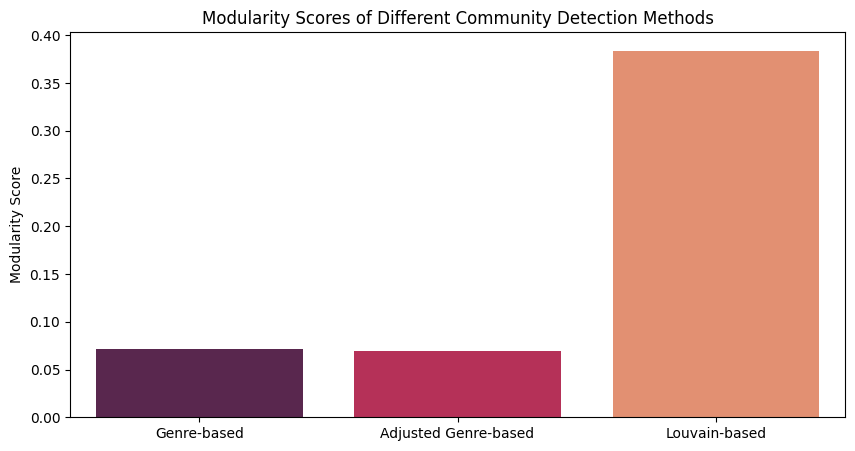

In [98]:
modularity_scores = [modularity_score, adjusted_modularity_score, louvain_modularity_score]
modularity_labels = ['Genre-based', 'Adjusted Genre-based', 'Louvain-based']
plt.figure(figsize=(10, 5))
sns.barplot(x=modularity_labels, y=modularity_scores, palette='rocket', hue=modularity_labels)
plt.ylabel('Modularity Score')
plt.title('Modularity Scores of Different Community Detection Methods')
plt.show()


The bar plot compares the modularity of the genre-based partitioning with the Louvain method. It is clear that the Louvain method achieves a much higher modularity than the genres. However, the modularity is still not close to its maximum, indicating that the network does not have a very strong community structure.

#### 1.3: Calculate the matrix $D$ and discuss your findings.

Next, we calculate the matrix  $D$ , a confusion matrix that compares the genres with the communities. This matrix helps us evaluate the alignment between genres and communities. As specified in the exercise, we will compute  $D$  only for the top 7 genres and top 7 communities, resulting in a  $7 \times 7$  matrix. Nodes that do not belong to the top 7 genres or communities will be excluded, so the matrix will not account for all nodes in the network.

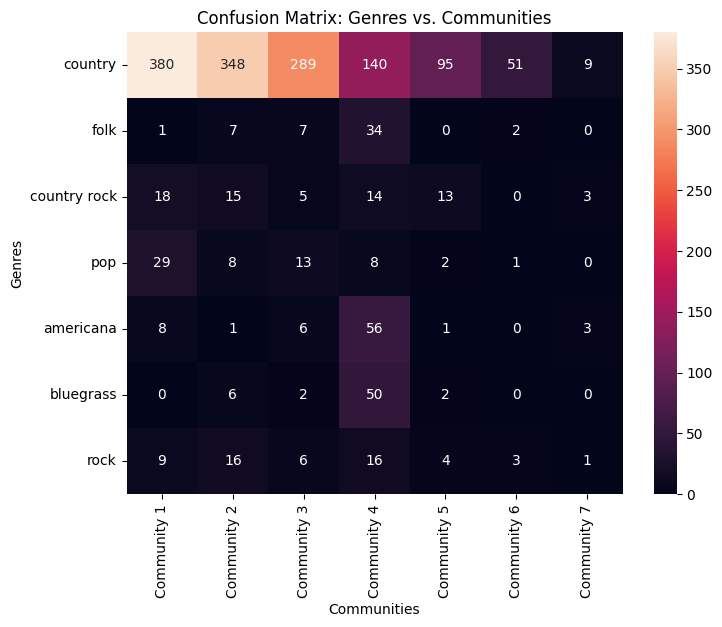

Sum of entries in D: 1682
Total nodes in the graph: 1832


In [109]:
# Normalize genre_dict keys
normalized_genre_dict = {normalize_name(k): v for k, v in genre_dict.items()}

# Identify the top 7 genres
all_genres = [genre for genres in normalized_genre_dict.values() for genre in genres]
genre_counts = Counter(all_genres)
top_genres = [genre for genre, count in genre_counts.most_common(7)]

# Identify the top 7 communities
community_counts = Counter(louvain_partition.values())
top_communities = [community for community, count in community_counts.most_common(7)]

D = np.zeros((7, 7), dtype=int)

# Populate the confusion matrix D with normalized node names
for node in G_filtered.nodes():
    normalized_node = normalize_name(node)
    node_genres = normalized_genre_dict.get(normalized_node, [])
    node_community = louvain_partition.get(node)
    if node_community in top_communities:
        community_index = top_communities.index(node_community)
        # Find the first genre in top_genres (if any) for the node and count it
        for genre in node_genres:
            if genre in top_genres:
                genre_index = top_genres.index(genre)
                D[genre_index, community_index] += 1
                break  # Only count the first matching genre to avoid double counting

df_D = pd.DataFrame(D, index=top_genres, columns=[f'Community {i+1}' for i in range(7)])

plt.figure(figsize=(8, 6))
sns.heatmap(df_D, annot=True, fmt='d', cmap='rocket')
plt.title('Confusion Matrix: Genres vs. Communities')
plt.xlabel('Communities')
plt.ylabel('Genres')
plt.show()

total_nodes_in_D = np.sum(D)
total_nodes_in_graph = G_filtered.number_of_nodes()
print("Sum of entries in D:", total_nodes_in_D)
print("Total nodes in the graph:", total_nodes_in_graph)

From the confusion matrix $D$ we can see that the genres and communities found by louvain don't match very well, since the diagonal elements are not the highest. This is also supported by the low modularity based on genres (so we didn't really expect the diagonal would be particularly high). 
Even after adjusting the genre assignments to skip `country` as the primary genre when possible, many artists still only have `country` as their genre. Additionally, the `country` genre is quite dispersed across multiple communities (1, 2, 3, 4, 5, and 6), which suggests that it doesn’t form a good community. The other top genres also show low matching with the top communities, as indicated by the dark colors in the matrix.


#### 1.4: Plot the communities and comment on your results.

Finally we plot the network and see how the artists are partitioned into communities based on genres and based on the louvain partition using the ForceAtlas package.

100%|██████████| 2000/2000 [00:37<00:00, 53.74it/s]


BarnesHut Approximation  took  3.81  seconds
Repulsion forces  took  31.55  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.82  seconds


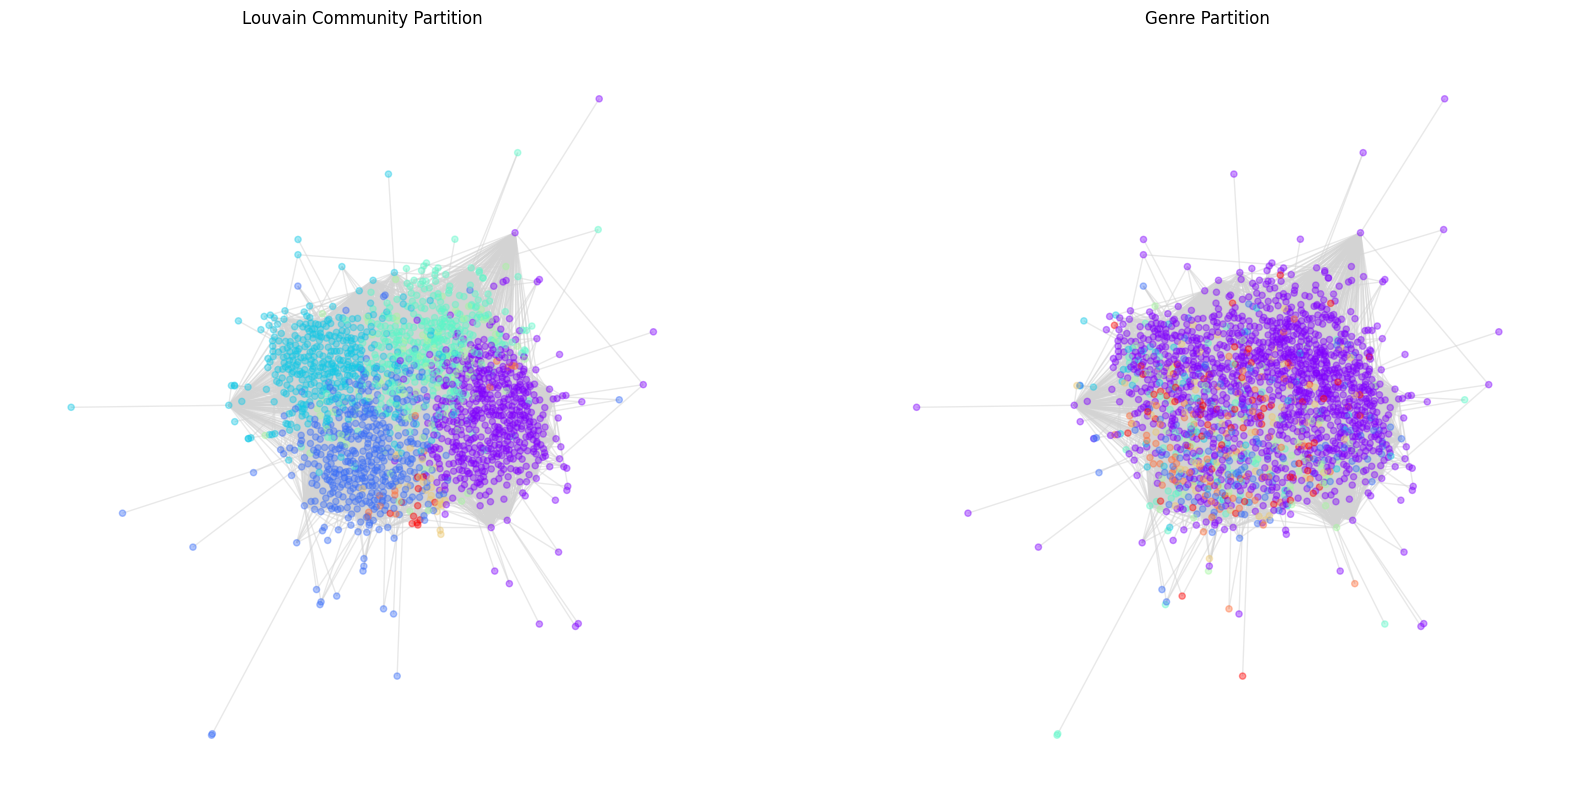

In [111]:
# here we remove some nodes because they were too far away from the main point cloud, and were causing the layout to be too spread out
outlier_nodes = ["honeyhoney", "The_Chuck_Wagon", "The_Chuck_Wagon_Gang"]
G_cleaned = G_filtered.copy()
G_cleaned.remove_nodes_from(outlier_nodes)

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)
positions = forceatlas2.forceatlas2_networkx_layout(G_cleaned, iterations=2000)

# **Partition by Louvain Method**
louvain_partition = community_louvain.best_partition(G_cleaned)

# Identify the largest communities 
community_sizes = Counter(louvain_partition.values())
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:10]
colors = cm.rainbow(np.linspace(0, 1, len(largest_communities)))

# set node colors 
node_colors_louvain = []
for node in G_cleaned.nodes():
    community_id = louvain_partition[node]
    if community_id in largest_communities:
        color_index = largest_communities.index(community_id)
        node_colors_louvain.append(colors[color_index])
    else:
        node_colors_louvain.append("lightgray")

# **Partition by Genre**
genre_colors = {genre: colors[i % len(colors)] for i, genre in enumerate(genre_communities)}
node_colors_genre = [genre_colors[G_cleaned.nodes[node]['genre']] for node in G_cleaned.nodes()]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].set_title("Louvain Community Partition")
nx.draw_networkx_nodes(G_cleaned, pos=positions, ax=axes[0], node_color=node_colors_louvain, node_size=20, alpha=0.4)
nx.draw_networkx_edges(G_cleaned, pos=positions, ax=axes[0], edge_color="lightgray", alpha=0.5)
axes[0].axis("off")

axes[1].set_title("Genre Partition")
nx.draw_networkx_nodes(G_cleaned, pos=positions, ax=axes[1], node_color=node_colors_genre, node_size=20, alpha=0.4)
nx.draw_networkx_edges(G_cleaned, pos=positions, ax=axes[1], edge_color="lightgray", alpha=0.5)
axes[1].axis("off")

plt.show()

From this visualization, it is clear that the Louvain method identifies more distinct and well separated communities, while the genre based partitioning results in one large “country” community (in purple) and several smaller communities for the remaining genres. Another interesting observation is that in the louvain method there seem to be four communities (blue, turquoise, green, and purple) that are relatively similar in size. This visualization again supports the modularity values calculated earlier in this assignment.

# Part 2: TF-IDF to understand genres and communities 📖

The questions below  are based on Lecture 7, part 2 and 3.

* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
* Calculate and visualize TF-IDF for the genres and communities.
* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

# Part 3: Sentiment of the artists and communities 💖

The questions below are based on Lecture 8

* Calculate the sentiment of the Artists pages (OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the largest communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?